# GazetoolsCL Test Notebook

In [1]:
import pkg_resources
import pyopencl as cl
import numpy as np
import pandas as pd
from scipy.ndimage import convolve1d as convolve1d_np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline

from gazetools import *

#### Select an OpenCL device to compute on. 

In [2]:
ctx = cl.create_some_context()

## Image Processing Tests

#### Load RGB test image

In [3]:
src1 = np.asarray(Image.open(pkg_resources.resource_filename("images", "PM5544_with_non-PAL_signals.png")))
print ("Source Dtype:",src1.dtype)
print ("Source Shape:",src1.shape)

('Source Dtype:', dtype('uint8'))
('Source Shape:', (576, 768, 3))


In [4]:
src2 = mpimg.imread(pkg_resources.resource_filename("images", "PM5544_with_non-PAL_signals.png"))
print ("Source Dtype:",src2.dtype)
print ("Source Shape:",src2.shape)

('Source Dtype:', dtype('float32'))
('Source Shape:', (576, 768, 3))


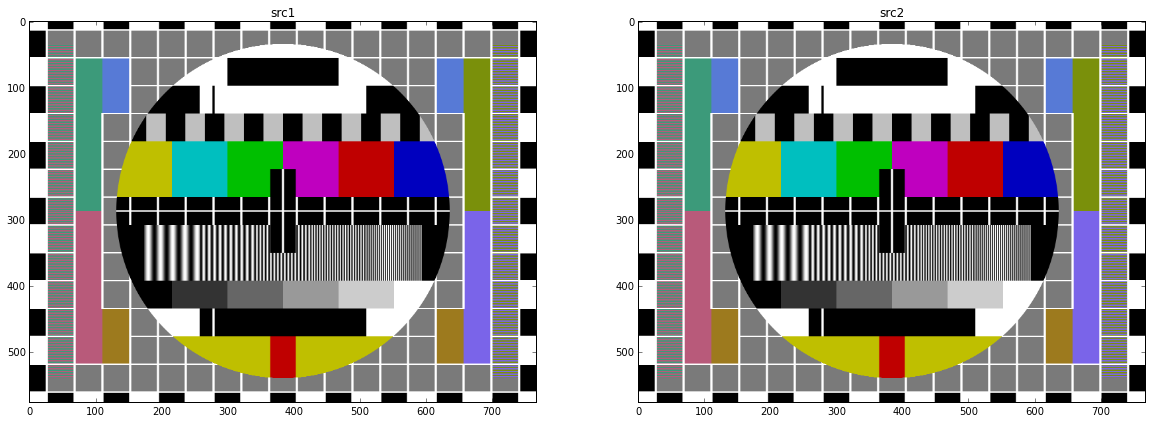

In [5]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(src1)
a.set_title("src1")
a=fig.add_subplot(1,2,2)
plt.imshow(src2)
a.set_title("src2")
plt.show()

#### Convert RGB test image to YCrCb

In [6]:
ycrcb1 = RGB2YCrCb(ctx, src1)
ycrcb2 = RGB2YCrCb(ctx, src2)

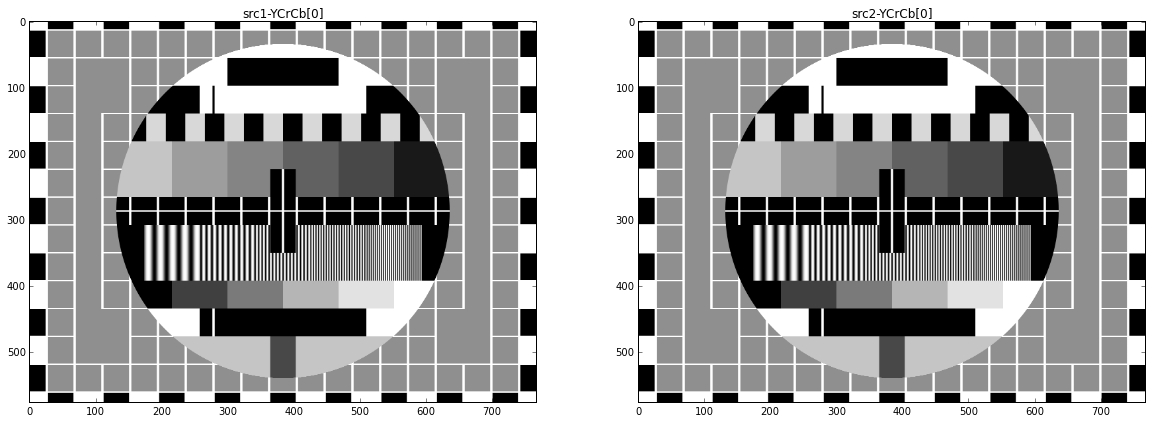

In [7]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(ycrcb1[:,:,0], cmap = cm.Greys_r)
a.set_title("src1-YCrCb[0]")
a=fig.add_subplot(1,2,2)
plt.imshow(ycrcb2[:,:,0], cmap = cm.Greys_r)
a.set_title("src2-YCrCb[0]")
plt.show()

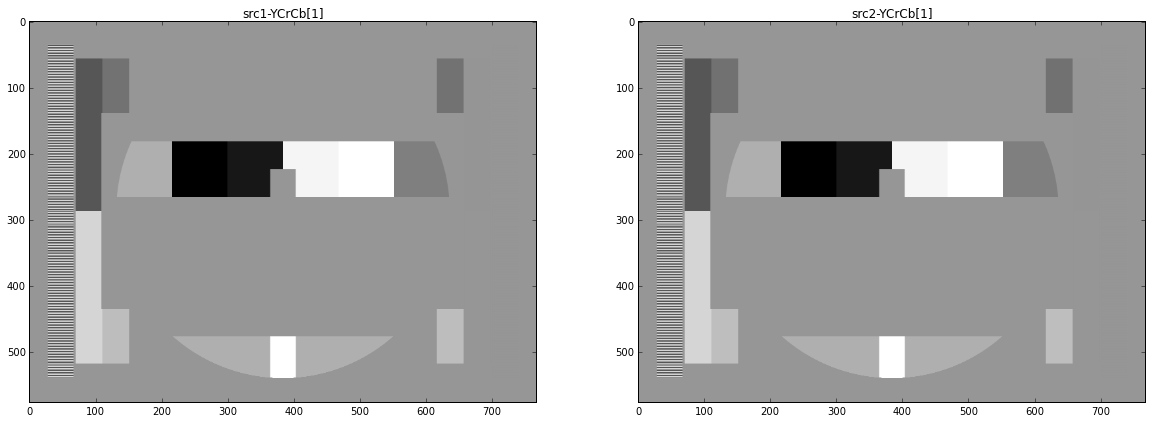

In [8]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(ycrcb1[:,:,1], cmap = cm.Greys_r)
a.set_title("src1-YCrCb[1]")
a=fig.add_subplot(1,2,2)
plt.imshow(ycrcb2[:,:,1], cmap = cm.Greys_r)
a.set_title("src2-YCrCb[1]")
plt.show()

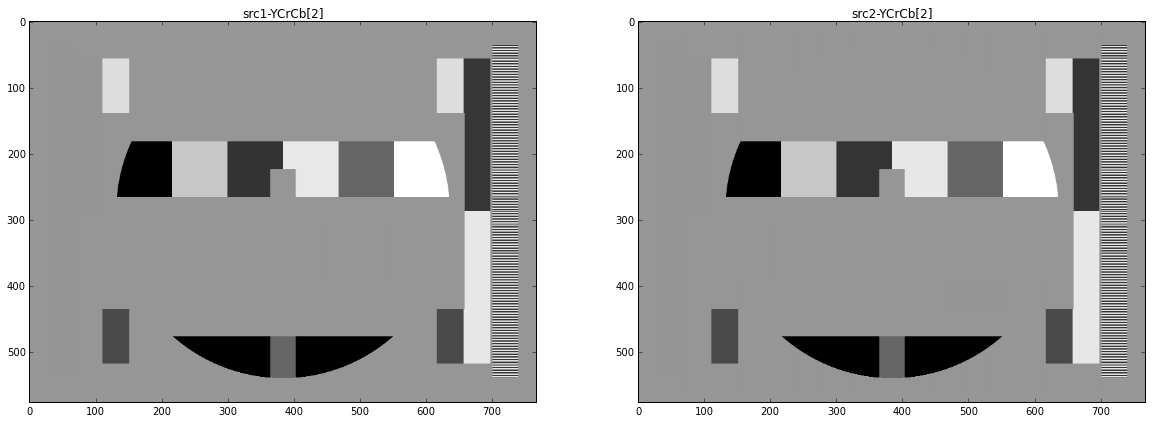

In [9]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(ycrcb1[:,:,2], cmap = cm.Greys_r)
a.set_title("src1-YCrCb[2]")
a=fig.add_subplot(1,2,2)
plt.imshow(ycrcb2[:,:,2], cmap = cm.Greys_r)
a.set_title("src2-YCrCb[2]")
plt.show()

#### Convert YCrCb test image back to RGB

In [10]:
rgb1 = YCrCb2RGB(ctx, ycrcb1)
rgb2 = YCrCb2RGB(ctx, ycrcb2)

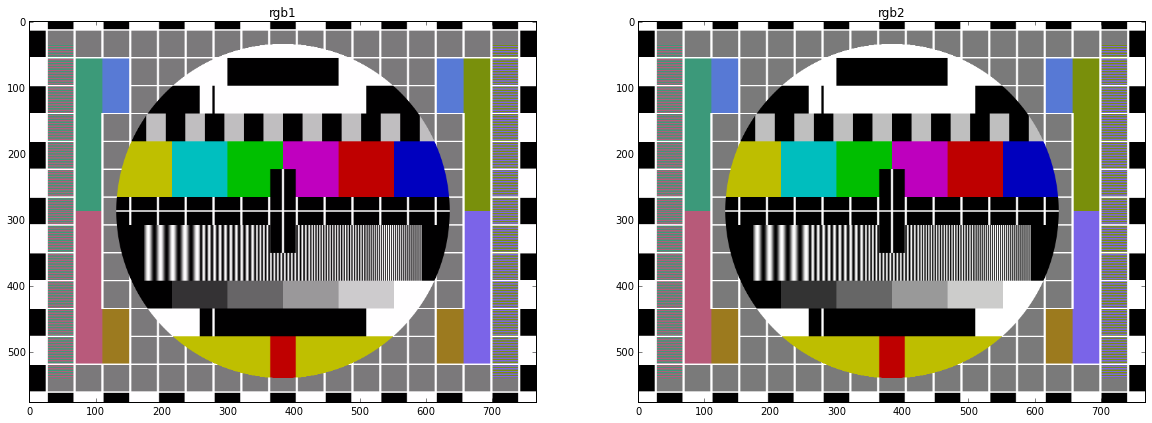

In [11]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(rgb1)
a.set_title("rgb1")
a=fig.add_subplot(1,2,2)
plt.imshow(rgb2)
a.set_title("rgb2")
plt.show()

## Visual Angle Tests

#### Constants

In [ ]:
sx = 1680 # horizontal screen resolution (px)
sy = 1050 # vertical screen resolution (px)
sw = 473.76 # physical screen width (mm)
sh = 296.1 # physical screen height (mm)

#### Distance of observer (in 3D space) from point on screen

In [ ]:
x = [0.0,0.0,1680.0/2.0,1680.0/2.0]
y = [0.0,1050.0/2.0,0.0,1050/2.0]
ez = [700.0]*4
ex = [0.0]*4
ey = [0.0]*4
distance_2_point(ctx, x, y, sx, sy, sw, sh, ez, ex, ey)

In [ ]:
x = [1680/2]
y = [1050/2]
ez = [700.0]
ex = [0.0]
ey = [0.0]
distance_2_point(ctx, x, y, sx, sy, sw, sh, ez, ex, ey)

#### Distance between two points in degrees of visual angle relative to observer (in 3D space)

In [ ]:
x1 = [0]
y1 = [1050/2]
x2 = [1680]
y2 = [1050/2]
ez = [700.0]
ex = [0.0]
ey = [0.0]
subtended_angle(ctx, x1, y1, x2, y2, sx, sy, sw, sh, ez, ex, ey)

In [ ]:
N = 1680 * 1050
x1 = np.tile(np.arange(1680),1050)
y1 = np.repeat(np.arange(1050), 1680)
x2 = [1680/2]*N
y2 = [1050/2]*N
ez = [700.0]*N
ex = [0.0]*N
ey = [0.0]*N
subtended_angle(ctx, x1, y1, x2, y2, sx, sy, sw, sh, ez, ex, ey)

## Filter Tests

##### Load test data

In [ ]:
df=pd.read_csv(pkg_resources.resource_filename("data","smi.csv"))
df.info()

#### Savitzky–Golay filter

##### Convolve smoothing filter with horizontal gaze coordinates

In [ ]:
smooth = savgol_coeffs(11, 2, 0, 1.0/500.0) # window length 2, order 2, derivitive 0
smooth

In [ ]:
x = np.array(df["smi_sxl"], dtype=np.float32) # horizontal gaze
x_np = convolve1d_np(x, smooth) # numpy reference
x_cl = convolve1d(ctx, x, smooth) # gazetools opencl implementation

In [ ]:
print x[11:-11]

In [ ]:
print x_np[11:-11]

In [ ]:
print x_cl[11:-11]

In [ ]:
t = np.arange(x.shape[0])
plt.plot(t,x,'r-')

In [ ]:
plt.plot(t,x_np,'g-',t,x_cl,'b-')

In [ ]:
x_diff = x_cl - x_np
plt.plot(t,x_diff)

In [ ]:
plt.plot(t[:11],x_diff[:11],"r-",t[:11],x_diff[len(x_diff)-11:],"b-")

##### Convolve 1st derivitive filter with horizontal gaze coordinates

In [ ]:
velocity = savgol_coeffs(11, 2, 1, 1.0/500.0) # window length 2, order 2, derivitive 0
velocity

In [ ]:
v_np = convolve1d_np(x, velocity) # numpy reference
v_cl = convolve1d(ctx, x, velocity) # gazetools opencl implementation

In [ ]:
plt.plot(t,v_np,'g-',t,v_cl,'b-')

##### Convolve image with 3x3 gaussian kernel